In [ ]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import torch
import random
import torch.nn as nn
import sklearn
import collections
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import json
from torch.optim import Adam
import pylab
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Penn/Colab/Data/')
from functions import load_model, save_model, Dataset, Trainer, mse_loss
from sklearn.metrics import roc_curve, auc

Mounted at /content/gdrive


## Load Data

In [ ]:
# Load Background data, which will be used for training
filename = 'BKG_dataset.h5'
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/BKG_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)

X_train = np.reshape(X_train, (-1, 19,3,1))
X_test = np.reshape(X_test, (-1, 19,3,1))
X_val = np.reshape(X_val, (-1, 19,3,1))

print(X_train.shape)

(640000, 57)
(640000, 19, 3, 1)


In [ ]:
BATCH_SIZE = 1024

In [ ]:
# Initialize datasets
train_dataset = Dataset(X=X_train, y=X_train)
test_dataset = Dataset(X=X_test, y=X_test)
val_dataset = Dataset(X=X_val, y=X_val)

In [ ]:
# Initialize dataloaders
train_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=True)
test_loader = test_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
val_loader = val_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
batch_X, batch_y = next(iter(train_loader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n")

Sample batch:
  X: [1024, 19, 3, 1]
  y: [1024, 19, 3, 1]



/content/gdrive/MyDrive/Penn/Colab/Data/functions.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
/content/gdrive/MyDrive/Penn/Colab/Data/functions.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


## CNN and Trainer Classes

In [ ]:
class CNN_VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_filters):
        """input_dim: array of the dimensions: [N, H, W, C]
        latent_dim: dimension of the latent space."""

        super(CNN_VAE, self).__init__()

        self.num_filters = num_filters
        self.input_dim = input_dim

        # Encoder layers
        self.conv1 = nn.Conv2d(input_dim[-1], self.num_filters, kernel_size=(3, 3), bias=False)
        self.avg_pool = nn.AvgPool2d(kernel_size=(2, 1))
        self.batch_norm1 = nn.BatchNorm2d(self.num_filters)
        self.fc_mean = nn.Linear((self.input_dim[1]//2)*self.input_dim[2]*self.num_filters, latent_dim)
        self.fc_logvar = nn.Linear((self.input_dim[1]//2)*self.input_dim[2]*self.num_filters, latent_dim)


        # Decoder layers
        self.fc1 = nn.Linear(latent_dim, (self.input_dim[1]//2)*self.input_dim[2]*self.num_filters)
        self.up_sample = nn.Upsample(scale_factor=(2, 1))
        self.zpad = nn.ZeroPad2d((0, 0, 1, 0))
        self.conv2 = nn.Conv2d(self.num_filters, self.input_dim[-1], kernel_size=(3, 3), bias=False)
        self.batch_norm2 = nn.BatchNorm2d(self.input_dim[-1])



    def forward(self, x_in):
        """Forward through the autoencoder with relu activation."""

        # Encoder
        x_in = (x_in.transpose(1, 3)).transpose(2, 3) # Transpose input [N, H, W, C] ==> [N, C, H, W]
        z = F.pad(x_in, pad=(1, 1, 1, 1)) # SAME padding to conserve dimensions
        z = self.conv1(z)
        z = self.avg_pool(z)
        z = self.batch_norm1(z)
        z = F.relu(torch.flatten(z, start_dim=1)) # Flatten tensor for dense layer
        mean = self.fc_mean(z)
        logvar = self.fc_logvar(z)

        # Reparameterization
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps*std

        # Decoder
        z = F.relu(self.fc1(z))
        z = torch.reshape(z, (-1, self.num_filters, self.input_dim[1]//2, self.input_dim[2]))
        z = self.up_sample(z)
        z = self.zpad(z)
        z = F.pad(z, pad=(1, 1, 1, 1)) # SAME padding to conserve dimensions
        z = self.conv2(z)
        z = F.relu(self.batch_norm2(z))
        z = (z.transpose(2, 3)).transpose(1, 3) # Transpose input [N, C, H, W] ==> [N, H, W, C]
        return z, mean, logvar

    def loss_function(self, x, y, mu, logvar, beta=0.42):
        """Compute the VAE loss. Beta was calculated to be roughly 0.4 for equal
        contribution of mse and kl loss terms."""
        # Reconstruction loss (MSE)
        mask = (y != 0)
        recon_loss = F.mse_loss(mask*x, mask*y, reduction='mean')

        # KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = (1 - beta)*recon_loss + beta*kl_loss
        return loss

In [ ]:
# Define a class which will handle training and testing the model
class Trainer(object):
    def __init__(self, model, num_batches_avg, loss_fn=None, optimizer=None, scheduler=None):
        """num_batches_avg: Number of batches to calculate the average loss over.
        example: if there are 625 batches, we might want to use 25, to calculate
        average loss over 25 batches."""

        #Set params
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_batches_avg = num_batches_avg

    def train_step(self, dataloader):
        """Train for one epoch.

        returns: average loss over most recent {num_batches_avg} batches, loss over most recent batch
        """

        self.model.train()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0

        # Iterate over batches in dataloader
        for i, batch in enumerate(dataloader):

            # Pass a single batch through the model and update the weights
            inputs, targets = batch
            self.optimizer.zero_grad()
            outputs, mu, logvar = self.model(inputs)
            loss = self.loss_fn(outputs, targets, mu, logvar)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            # Update loss metrics
            running_loss += loss.item()
            current_loss = loss.item()

            # Calculate the average loss
            if i % self.num_batches_avg == self.num_batches_avg - 1:
                avg_loss = running_loss / self.num_batches_avg
                running_loss = 0.0

        return avg_loss, current_loss

    def eval_step(self, dataloader):
        """validation or test step over one epoch."""

        self.model.eval()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0
        y_trues, model_outputs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, y_true = batch
                outputs, mu, logvar = self.model(inputs)
                loss = self.loss_fn(outputs, y_true, mu, logvar)

                # Update loss metrics
                running_loss += loss.item()
                current_loss = loss.item()

                # Calculate the average loss
                if i % self.num_batches_avg == self.num_batches_avg - 1:
                    avg_loss = running_loss / self.num_batches_avg
                    running_loss = 0.0

                # Store outputs
                y_trues.extend(y_true)
                model_outputs.extend(outputs)
        return avg_loss, current_loss, np.vstack(y_trues), np.vstack(model_outputs)

    def predict_step(self, dataloader):
        """Prediction step."""
        self.model.eval()
        model_outputs = []

        # Iterate over batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, targets = batch
                outputs, mu , logvar = self.model(inputs)

                # Store outputs
                model_outputs.extend(outputs)

        return np.vstack(model_outputs), np.vstack(mu), np.vstack(logvar)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        """Train the neural net."""

        best_val_loss = np.inf
        patience_counter=patience

        # Loop over epochs
        for epoch in range(num_epochs):

            # Steps
            avg_train_loss, last_train_loss = self.train_step(dataloader=train_dataloader)
            avg_val_loss, last_val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = self.model
                patience_counter = patience # reset patience
            else:
                patience_counter -= 1
            if not patience_counter: # 0
                print("Stoping Early!")
                break

            # Logging
            print(f'Epoch: {epoch+1} | '
            f'average train loss over most recent {self.num_batches_avg} batches: {avg_train_loss},'
            f'average val loss over most recent {self.num_batches_avg} batches: {avg_val_loss},'
            #f'learning rate: {self.optimizer.param_groups[0]['lr']:.2E},'
            f'patience counter: {patience_counter}')

        return best_model

## Initialize Model and Train

In [ ]:
# Define consts
LEARNING_RATE = 1e-3
PATIENCE = 6
NUM_EPOCHS = 33

In [ ]:
# Initialize model
INPUT_DIM = X_train.shape
NUM_FILTERS = 10
LATENT_DIM = 8
conv_VAE = CNN_VAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, num_filters=NUM_FILTERS)
print(conv_VAE.named_parameters)

<bound method Module.named_parameters of CNN_VAE(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (avg_pool): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_mean): Linear(in_features=270, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=270, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=270, bias=True)
  (up_sample): Upsample(scale_factor=(2.0, 1.0), mode='nearest')
  (zpad): ZeroPad2d((0, 0, 1, 0))
  (conv2): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)>


In [ ]:
# Initialize the loss function, optimizer and lr scheduler, trainer
def loss_fn(x, y, mu, logvar):
    return conv_VAE.loss_function(x, y, mu, logvar)
optimizer = Adam(params=conv_VAE.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3, verbose=True)
trainer = Trainer(model=conv_VAE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    num_epochs=NUM_EPOCHS, patience=PATIENCE,
    train_dataloader=train_loader, val_dataloader=val_loader)

/content/gdrive/MyDrive/Penn/Colab/Data/functions.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
/content/gdrive/MyDrive/Penn/Colab/Data/functions.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


Epoch: 1 | average train loss over most recent 25 batches: 33.72615440368652,average val loss over most recent 25 batches: 33.9117554473877,patience counter: 6
Epoch: 2 | average train loss over most recent 25 batches: 27.27228385925293,average val loss over most recent 25 batches: 27.6880850982666,patience counter: 6
Epoch: 3 | average train loss over most recent 25 batches: 23.297579727172852,average val loss over most recent 25 batches: 22.997331619262695,patience counter: 6
Epoch: 4 | average train loss over most recent 25 batches: 18.882295570373536,average val loss over most recent 25 batches: 18.252813034057617,patience counter: 6
Epoch: 5 | average train loss over most recent 25 batches: 15.077839469909668,average val loss over most recent 25 batches: 14.60657527923584,patience counter: 6
Epoch: 6 | average train loss over most recent 25 batches: 12.054396934509278,average val loss over most recent 25 batches: 11.866240844726562,patience counter: 6
Epoch: 7 | average train loss

In [ ]:
# Save model
save_model(best_model, 'CNN_VAE_3')

In [ ]:
# Load model
conv_VAE = CNN_VAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, num_filters=NUM_FILTERS)
conv_VAE = load_model(conv_VAE, 'CNN_VAE_3')
trainer = Trainer(model=conv_VAE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Calculate the appropriate beta value for loss function
# (We want the mse and kl loss terms to be roughly equal contributions)

outputs, mu, logvar = conv_VAE(batch_X)
mask = (batch_X != 0)
_mse_loss = F.mse_loss(mask*outputs, mask*batch_X, reduction='mean')
kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
beta = _mse_loss / (kl_loss + _mse_loss)
print(f'mse loss: {_mse_loss}')
print(f'kl loss: {kl_loss}')
print(f'beta: {beta}')

mse loss: 0.3552989661693573
kl loss: 0.8027564883232117
beta: 0.3068065345287323


In [ ]:
#bkg_prediction = trainer.predict_step(dataloader=test_loader)
bkg_prediction, bkg_mu, bkg_logvar = conv_VAE(torch.tensor(X_test, requires_grad=False).float())
bkg_prediction = bkg_prediction.detach().numpy()

In [ ]:
# add correct signal labels
signal_labels = ['Ato4l', 'hChToTauNu', 'hToTauTau', 'leptoquark']

In [ ]:
# add correct path to signal files
drive_path = '/content/gdrive/MyDrive/Penn/Colab/Data/'
signals_file = [drive_path+label+'_dataset.h5' for label in signal_labels]
print(signals_file)

['/content/gdrive/MyDrive/Penn/Colab/Data/Ato4l_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hChToTauNu_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hToTauTau_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/leptoquark_dataset.h5']


In [ ]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])
    test_data = np.reshape(test_data, (-1, 19, 3, 1))
    signal_data.append(test_data)

print(np.array(signal_data).shape)

(4,)


<ipython-input-16-c5d333d51caa>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(signal_data).shape)


In [ ]:
signal_results = []
sig_mu = []
sig_logvar = []

for i, label in enumerate(signal_labels):
    signal_prediction, mu, logvar = conv_VAE(torch.tensor(signal_data[i], requires_grad=False).float())
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal
    sig_mu.append(mu)
    sig_logvar.append(logvar)

## MSE AD Score

In [ ]:
def mse_loss_masked(y, x):
    mask = (y != 0)
    return mse_loss(mask*y, mask*x)

In [ ]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss_masked(np.reshape(X_test, (-1, 57)),
                           np.reshape(bkg_prediction.astype(np.float32), (-1, 57))))
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss_masked(np.reshape(signal_X, (-1, 57)),
                               np.reshape(signal_results[i][2].detach().numpy().astype(np.float32), (-1, 57))))

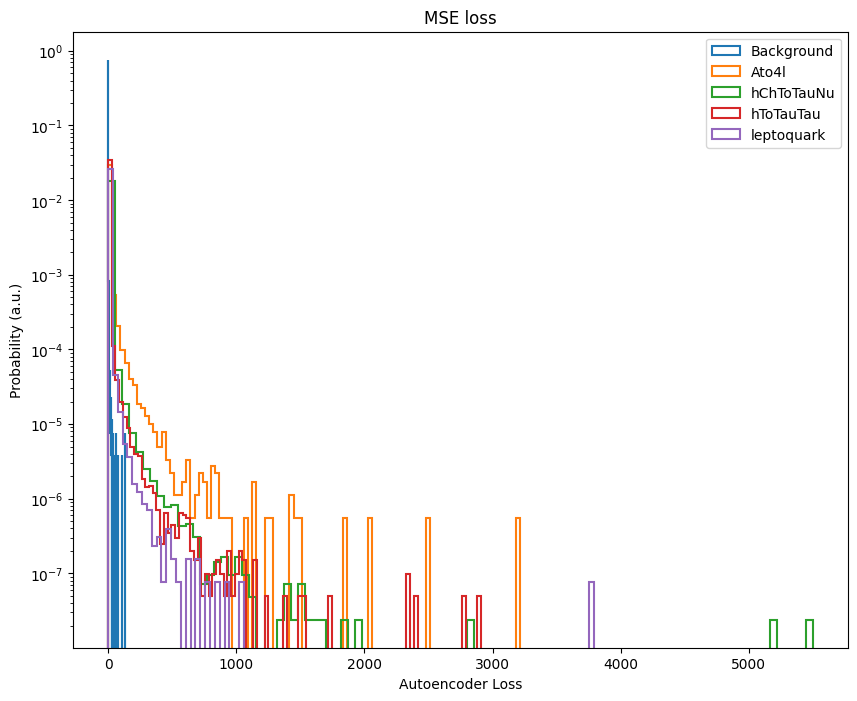

In [ ]:
bin_size=100
labels = np.concatenate([['Background'], np.array(signal_labels)])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

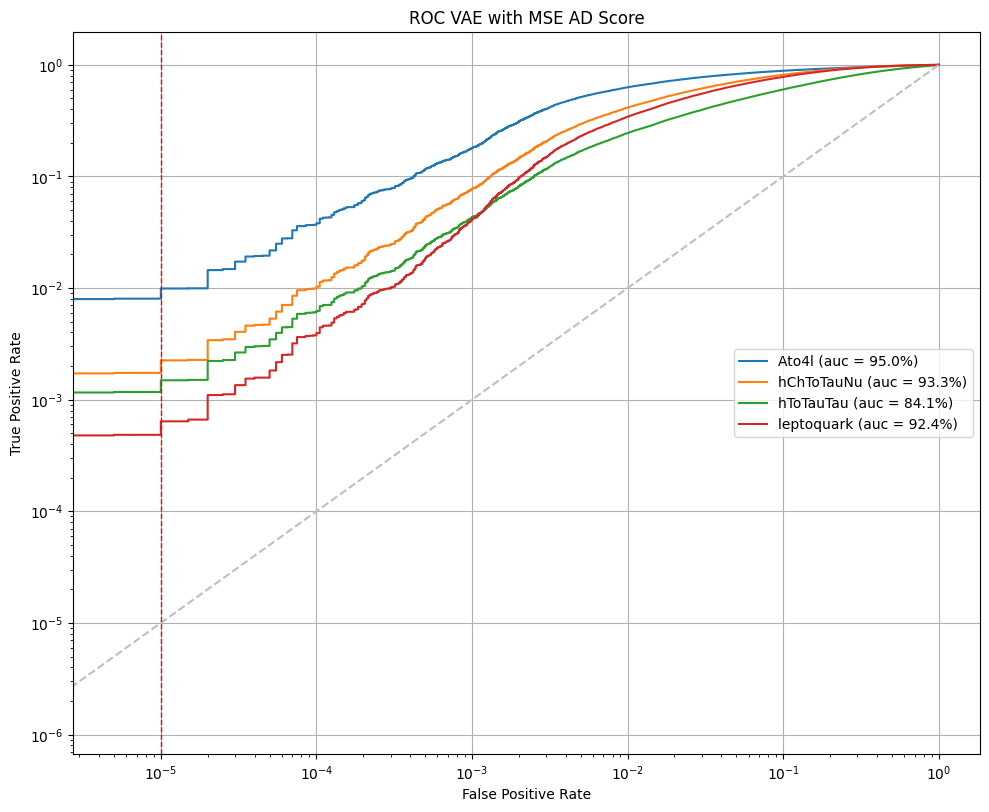

In [ ]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC VAE with MSE AD Score")
plt.show()

## KL AD Score

In [ ]:
# Define AD score
def AD_score(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

In [ ]:
total_loss = []

total_loss.append(AD_score(bkg_mu, bkg_logvar).detach())
for i, signal_X in enumerate(signal_data):
    total_loss.append(AD_score(sig_mu[i], sig_logvar[i]).detach())

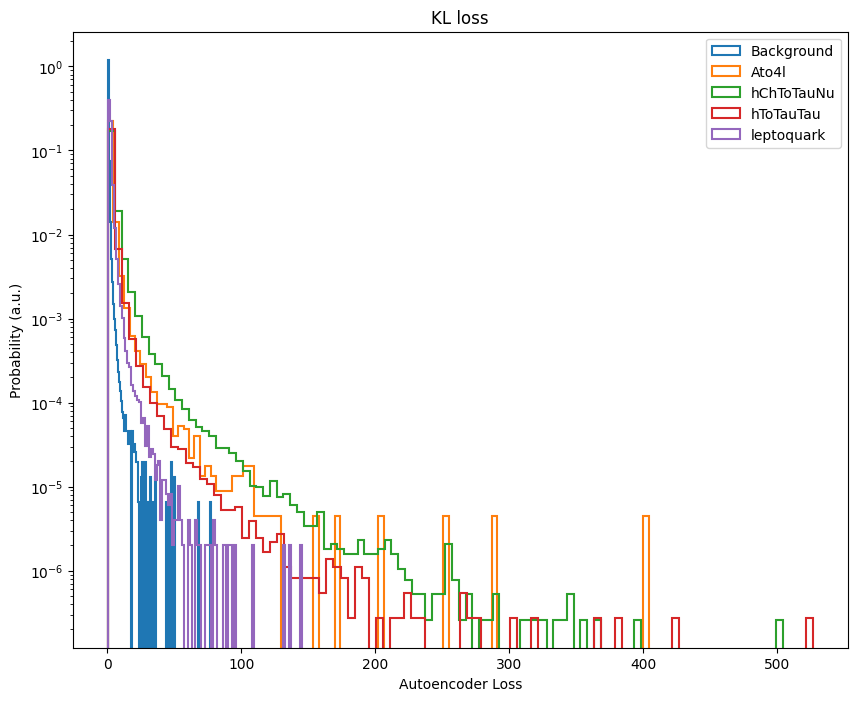

In [ ]:
bin_size=100
labels = np.concatenate([['Background'], np.array(signal_labels)])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

#plt.hist(total_loss[0], bins=bin_size, label='background', density = True, histtype='step', fill=False, linewidth=1.5)
#plt.hist(total_loss[1], bins=bin_size, label='Ato4l', density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('KL loss')
plt.legend(loc='best')
plt.show()

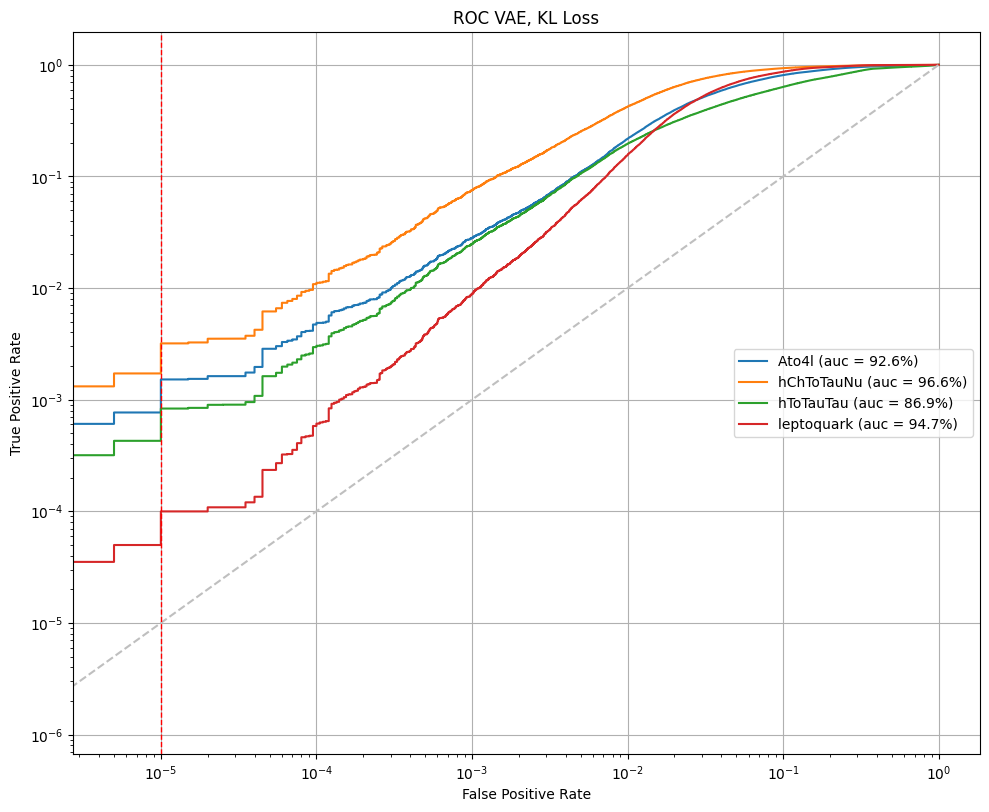

In [ ]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC VAE, KL Loss")
plt.show()

## Evaluation

In [ ]:
# Calculate the threshold for a give rejection rate using the background datset

REJECTION_RATE = pow(10, 4)


# Calculate fpr, tpr, thresholds
trueVal = target_background
predVal_loss = np.array(total_loss[0])
fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss, drop_intermediate=False)

# Loop over thresholds
for i, thresh in enumerate(threshold_loss):
    preds = (predVal_loss >= thresh)
    rejection_rate = (len(preds) - np.sum(preds)) / np.sum(preds) # number of background / number of anomaly

    # Breaking
    if rejection_rate < REJECTION_RATE:
        break

    threshold = thresh # update threshold

pred_test = (predVal_loss >= threshold)
print(f'\nrejection rate = {(len(pred_test) - np.sum(pred_test)) / np.sum(pred_test):.2f}')
print(f'threshold = {threshold:.2f}\n\n')


rejection rate = 10525.32
threshold = 28.18




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
<ipython-input-26-ef13861a7d00>:14: RuntimeWarning: divide by zero encountered in long_scalars
  rejection_rate = (len(preds) - np.sum(preds)) / np.sum(preds) # number of background / number of anomaly


In [ ]:
from IPython.display import Javascript

<IPython.core.display.Javascript object>


Ato4l:
length of dataset: 55969
TP = 232
TPR = 0.9243



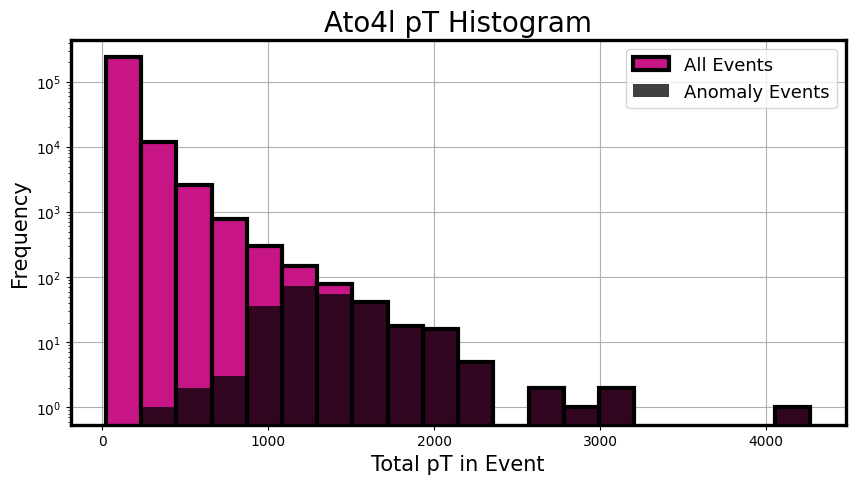

<ipython-input-28-a66d56fd86ba>:57: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(bin_centers, pT_hist_B/pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=2.5, zorder=2)


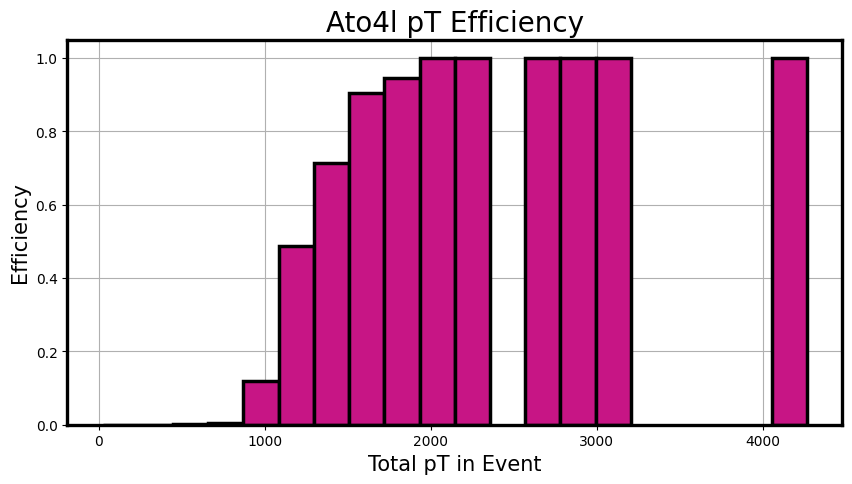

_________________________________________________________________________________________________

hChToTauNu:
length of dataset: 760272
TP = 7323
TPR = 0.9974



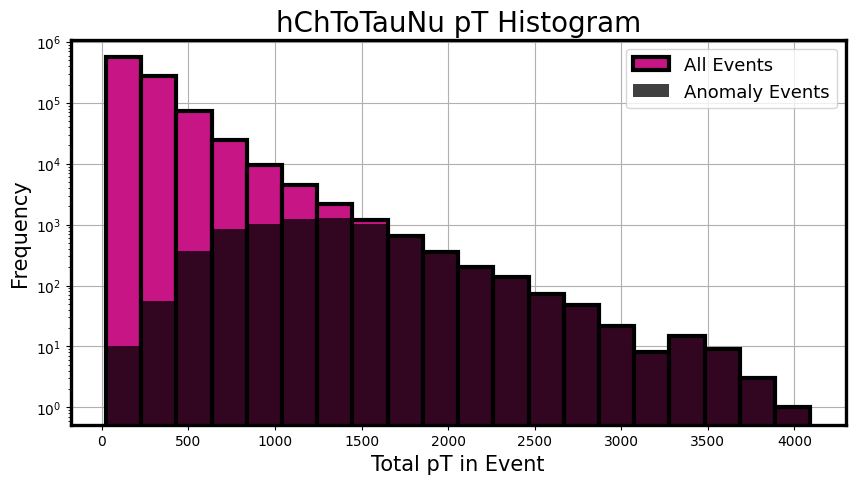

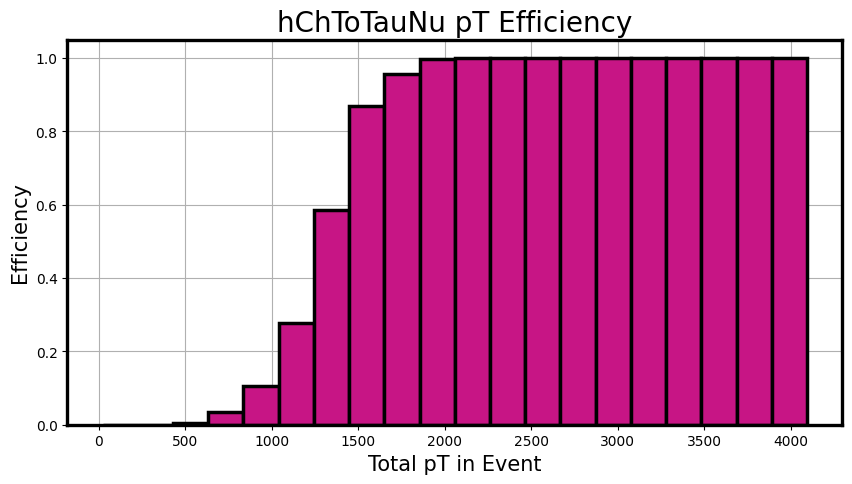

_________________________________________________________________________________________________

hToTauTau:
length of dataset: 691283
TP = 1793
TPR = 0.9895



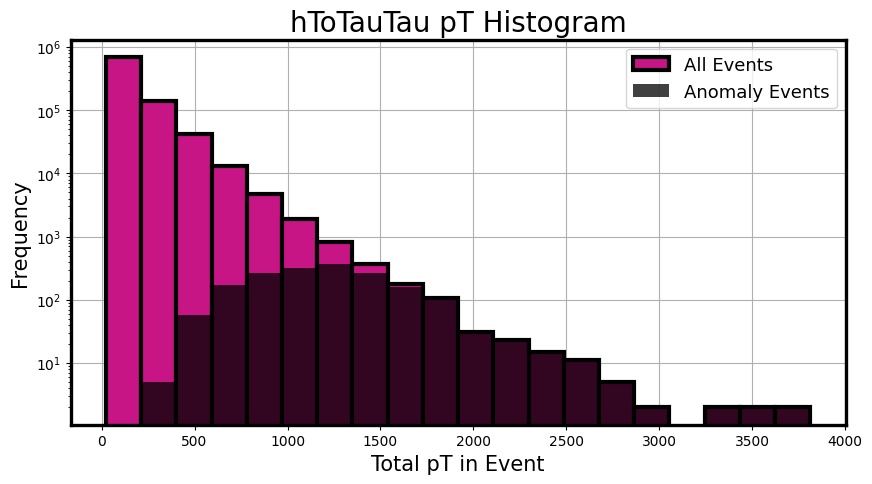

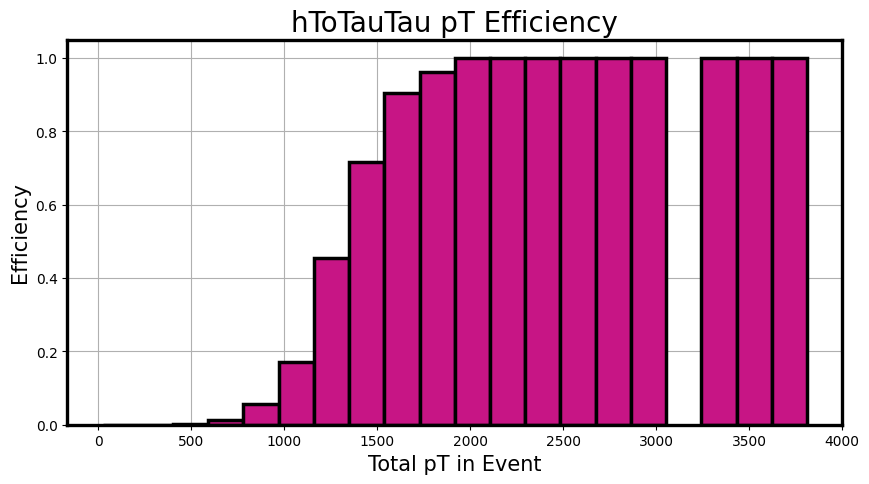

_________________________________________________________________________________________________

leptoquark:
length of dataset: 340544
TP = 162
TPR = 0.8950



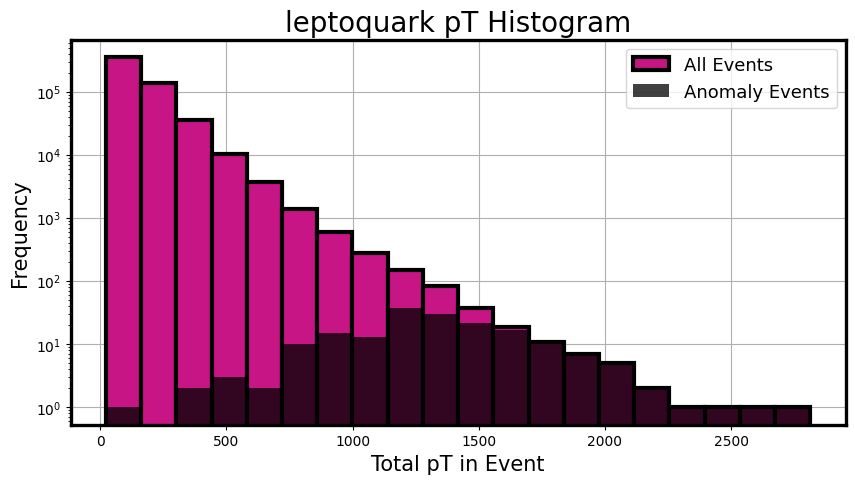

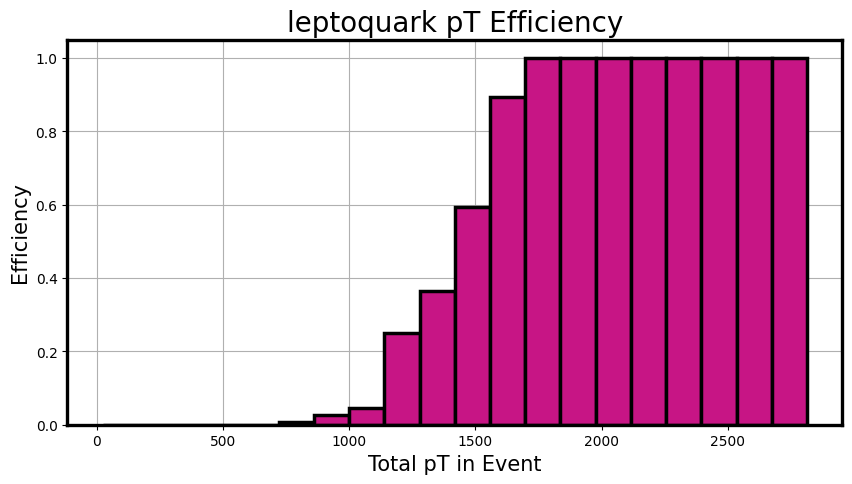

_________________________________________________________________________________________________


In [ ]:
# Calcalate the TPR and efficiency of each signal dataset


display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 20000})''')) # No scroll bar

# Loop over signal datasets
for i, label in enumerate(labels):
    if i ==0: continue # background

    # Calculate TPR
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    true_indices = np.nonzero(trueVal)[0] # true anomaly indices
    predVal = 1 * (np.concatenate((total_loss[i], total_loss[0])) >= threshold) # 1=anomaly, 0=bkg
    pred_indices = np.nonzero(predVal)[0] # indices of anomaly prediction
    TP = len(np.intersect1d(pred_indices, true_indices)) # the number of elements shared between trueVal and predVal
    TPR = TP / np.sum(trueVal)

    # Printing
    print(f'\n{label}:')
    print(f'length of dataset: {total_loss[i].shape[0]}')
    print(f'TP = {TP}')
    print(f'TPR = {TPR:.4f}\n')

    # Get pT from data
    X = np.concatenate((signal_data[i-1], X_test)).reshape(-1, 19, 3, 1) # Data beore going through model
    pT = X[:, 1:, 0, 0]
    pT_max = np.max(pT, axis=1) # Maximum pT in each event
    pT_sum = np.sum(pT, axis=1) # Sum of the pT in each event

    # Make histograms
    pT_hist_A, edges_A = np.histogram(pT_sum, bins=20) # all events
    pT_hist_B, edges_B = np.histogram(pT_sum[pred_indices], bins=20, range=(pT_sum.min(), pT_sum.max())) # only events predicted as anomalous
    bin_centers = edges_A[0:-1] + ((edges_A[1] - edges_A[0])/2)


    # Plot Histograms
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Histogram', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.bar(bin_centers, pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=3, zorder=2, label='All Events')
    plt.bar(bin_centers, pT_hist_B, width=(edges_A[1] - edges_A[0]), color='k', zorder=3, label='Anomaly Events', alpha=0.75)
    plt.yscale('log')
    plt.legend(fontsize=13)
    plt.show()
    print('')

    # Plot Efficiency
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Efficiency', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Efficiency', fontsize=15)
    plt.bar(bin_centers, pT_hist_B/pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=2.5, zorder=2)
    plt.show()
    print('_________________________________________________________________________________________________')